# Make buoy data file

Standardize buoy data and put it together in a Pandas dataframe.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('max_rows', 6)  # max number of rows to show in this notebook — to save space!

from matplotlib.dates import date2num
import numpy as np
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import os
from collections import OrderedDict
from datetime import datetime, timedelta
import datedelta
import gsw
import tabs
import shapely
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

# https://stackoverflow.com/questions/47404653/pandas-0-21-0-timestamp-compatibility-issue-with-matplotlib
from pandas.tseries import converter
converter.register() 

/Users/kthyng/miniconda3/envs/cart/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
base = 'drive_data/'

In [3]:
run buoy_info.py

In [4]:
savename = base + 'data.csv'
dstart = '2017-06-01'; dend = '2018-3-1'
tz = 'UTC'  # 'US/Central'
baseurl = 'http://pong.tamu.edu/'  # or 'http://localhost/'


In [5]:
g = 9.81  # m/s^2
if not os.path.exists(savename):
        
    # Stream gauges
    stations = ['08078000', '08077600', '08074500', '08068500', '08068090', '08070500', '08071000', 
                '08070200', '08071280', '08067252', '08075730', '08075605', '08075400', '08075000',
                '08073700', '08074540', '08075770', '08076500', '08076000', '08076180', '08067525',
                '08067500', '08066500', '08042558']  
    df = tabs.read(stations, dstart, dend, resample=('15T',0,'mean'))
              
    # Gauge height
    station = '08072000'
    df = df.join(tabs.read(station, dstart, dend, resample=('15T',0,'mean'), var='height'))
              
    # Reservoir storage
    station = '08072000'
    df = df.join(tabs.read(station, dstart, dend, resample=('15T',0,'mean'), var='storage'))

    
    ## TWDB ##
    names = ['FISH', 'MIDG', 'OLDR', 'TRIN', 'BOLI']
    for name  in names:
        df = df.join(tabs.read(name, dstart, dend, resample=('15T',0,'mean')))

    ## TABS ##
    df = df.join(tabs.read('B', dstart, dend, resample=('15T',0,'mean')))
            
    ## NOS/NDBC buoys ##
    stations = ['8771486','8770613','8771013','8771341','8771450','42035','8770808','8770777','8770822','8770971','8771972']
    for station in stations:
        df = df.join(tabs.read(station, dstart, dend, resample=('15T',0,'mean')))
    
    ## Vertical datum
    # The vertical datum for the bathymetry is mean high water (in file "Galveston_DEM_metadata.html"). 
    # The sea level measurements that I use are in mean sea level, so need to adjust.
    # using station datum information from e.g. https://tidesandcurrents.noaa.gov/datums.html?id=8771013
    df['8771013: Water Level [m]'] -= (1.610 - 1.467)  # MHW - MSL datums, meters
    df['8771341: Water Level [m]'] -= (3.249 - 3.072)  # MHW - MSL datums, meters
    df['8770777: Water Level [m]'] -= (2.140 - 1.951)  # MHW - MSL datums, meters
    df['8770613: Water Level [m]'] -= (1.967 - 1.807)  # MHW - MSL datums, meters
    df['8771450: Water Level [m]'] -= (1.739 - 1.588)  # MHW - MSL datums, meters
    df['8771486: Water Level [m]'] -= (6.311 - 6.183)  # MHW - MSL datums, meters
    df['8771972: Water Level [m]'] -= (1.621 - 1.498)  # MHW - MSL datums, meters
    df['8770971: Water Level [m]'] -= (1.425 - 1.259)  # MHW - MSL datums, meters
    df['8770808: Water Level [m]'] -= (4.462 - 4.299)  # MHW - MSL datums, meters
    df['8770822: Water Level [m]'] -= (1.507 - 1.308)  # MHW - MSL datums, meters
    
    
    ## currents with depth in entrance channel ##
    # have to loop over each month
    url = 'https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&request=GetObservation&version=1.0.0&observedProperty=sea_water_speed&direction_of_sea_water_velocity&offering=urn:ioos:station:NOAA.NOS.CO-OPS:g06010&responseFormat=text/csv&eventTime='
    # along-channel direction
    diralong = 90 - bys['g06010']['angle']
    if diralong < 0:
        diralong += 360
    
    dst = pd.Timestamp(dstart)
    while dst < pd.Timestamp(dend):
        den = dst + datedelta.MONTH - pd.Timedelta('15 minutes')

        # read in data for month
        # first check there is data
        d1 = pd.read_csv(url + dst.strftime('%Y-%m-%dT00:00:00Z/') + den.strftime('%Y-%m-%dT%H:%M:%SZ'))
        if len(d1) < 10:  # no data, so go to next datetime
            dst += datedelta.MONTH
            continue
        d = pd.read_csv(url + dst.strftime('%Y-%m-%dT00:00:00Z/') + den.strftime('%Y-%m-%dT%H:%M:%SZ'), parse_dates=True, index_col=4).tz_localize('UTC')
        d = d[['sea_water_speed (cm/s)', 'direction_of_sea_water_velocity (degree)', 'sea_water_temperature (C)', 'bin_distance (m)']]

        # pivot to get times as rows and depths as columns
        d = pd.pivot_table(d, index=['bin_distance (m)', 'date_time'] )
        depths = d.index.get_level_values(0).drop_duplicates().get_values()

        # initialize columns
        if not 'g06010: Along [cm/s], depth ' + str(depths[0]) + ' [m]' in df.columns:
            for depth in depths:
                df['g06010: Along [cm/s], depth ' + str(depth) + ' [m]'] = np.nan
                df['g06010: Across [cm/s], depth ' + str(depth) + ' [m]'] = np.nan
                df['g06010: WaterT [deg C]'] = np.nan

        # calculations
        for depth in depths:

            theta = d.loc[depth]['direction_of_sea_water_velocity (degree)'].copy()
            # convert to math angles
            theta = 90 - theta
            theta[theta<0] += 360

            # calculate u and v
            east = d.loc[depth]['sea_water_speed (cm/s)']*np.cos(np.deg2rad(theta))
            north = d.loc[depth]['sea_water_speed (cm/s)']*np.sin(np.deg2rad(theta))

            # calculate along and across velocity
            df.loc[dst.isoformat():den.isoformat(),'g06010: Along [cm/s], ' + 'depth ' + str(depth) + ' [m]'] = (east*np.cos(np.deg2rad(diralong)) + north*np.sin(np.deg2rad(diralong))).resample('15T', base=0).mean()
            df.loc[dst.isoformat():den.isoformat(),'g06010: Across [cm/s], ' + 'depth ' + str(depth) + ' [m]'] = (-east*np.sin(np.deg2rad(diralong)) + north*np.cos(np.deg2rad(diralong))).resample('15T', base=0).mean()
        df.loc[dst.isoformat():den.isoformat(),'g06010: WaterT [deg C]'] = d.loc[depth]['sea_water_temperature (C)'].resample('15T', base=0).mean()
        dst += datedelta.MONTH
          
    # Also single time series, for comparison
    df = df.join(tabs.read('g06010', dstart, dend, resample=('15T',0,'mean')))
    
    ## Precipitation data ##
    # this data is locally saved because it is not freely available online
    stations = ['08067000', '08077650', '08073600']
    for station in stations:
        # rain is in inches
        rain = pd.read_csv('drive_data/' + station + '-precip.csv', comment='#', parse_dates=True, index_col=0, usecols=[0,2]).tz_localize('UTC')
        rain *= 2.54  # convert from inches to centimeters
        df[station + ': Rain [cm]'] = rain
            
    df.tz_localize(None).to_csv(savename)
else:
    df = pd.read_csv(savename, parse_dates=True, index_col=0)

In [13]:
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])
pc = cartopy.crs.PlateCarree()
merc = cartopy.crs.Mercator(central_longitude=-85.0)

plots = {'Water Level [m]': {'color': '0.1', 'marker': 'o', 's': 200, 'alpha': 1, 'linewidths': 2}, 
         'Gage height [m]': {'marker': 'o', 's': 200, 'alpha': 1}, 
         'East [m/s]': {'color': 'w', 'marker': 'v', 's': 120, 'alpha': 1},
         'Salinity': {'color': 'w', 'marker': '*', 's': 280, 'alpha': 1}, 
         'Along [cm/s]': {'color': 'w', 'marker': '^', 's': 150, 'alpha': 1},
         'Rain [cm]': {'marker': 's', 's':200, 'alpha': 1},
         'Flow rate [m^3/s]': {'marker': '>', 's': 200, 'alpha': 1}}

base = 'drive_data/'


In [14]:
run buoy_info.py

<Figure size 432x288 with 0 Axes>

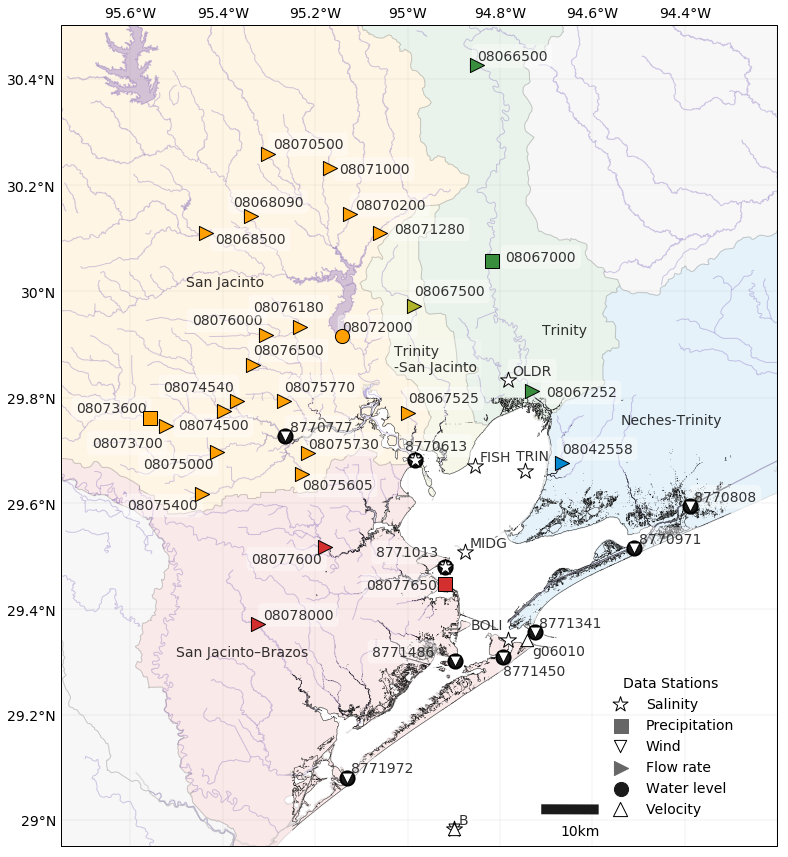

In [15]:
d = np.load('drive_data/bathy_galv_clean.npz')  # all of Galveston Bay
bathy = d['bathy']; dx = d['dx']; dy = d['dy']; lon = d['lon']; lat = d['lat']
bathyo = np.load('drive_data/bathy_every_fifth.npz')['bathy'][::-1,:][1:-1,1:-1]  # all
bathyo = np.ma.masked_where(bathyo>0, bathyo)

extent = [-95.75, -94.2, 28.95, 30.5]
x1, x2, y1, y2 = extent
pts = np.array([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])
ext = shapely.geometry.Polygon(pts)


fig = plt.figure(figsize=(14, 12))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent(extent, pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.2))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.2))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False

# bathymetry, but only near bay
# mappable = ax.contourf(lon, lat, bathyo, [-25, -20, -15, -10, -8, -6, -4, -2, 0], vmin=-40, cmap=cmo.gray, transform=pc)
# cb = fig.colorbar(mappable, orientation='horizontal', shrink=0.5, pad=0.025)
# cb.set_label('Depth [m]')

# # add background land
# ax.add_feature(land_10m)

# add bay-area detailed coastline
ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline


# Add river basins to plot
reader = cartopy.io.shapereader.Reader('drive_data/Major_River_Basins_Shapefile/TWDB_MRBs_2014.shp')
basins = reader.records()
for basin in basins:
    if basin.attributes['basin_name'] == 'San Jacinto-Brazos':
        facecolor = buoys['OLDR']['color']  # 'red'
    elif basin.attributes['basin_name'] == 'San Jacinto':
        facecolor = buoys['TRIN']['color']  # 'orange'
    elif basin.attributes['basin_name'] == 'Trinity-San Jacinto':
        facecolor = buoys['8771013']['color']  # 'yellow'
    elif basin.attributes['basin_name'] == 'Trinity':
        facecolor = buoys['8771341']['color']  # 'green'
    elif basin.attributes['basin_name'] == 'Neches-Trinity':
        facecolor = buoys['8771972']['color']  # 'blue'
    else:
        facecolor = '0.7'
    ax.add_geometries([basin.geometry], pc, facecolor=facecolor, edgecolor='k', linewidth=1, alpha=0.1)

watercolor = buoys['8770808']['color']

# Add lakes to plot
reader = cartopy.io.shapereader.Reader('drive_data/tceq_segments_2014_shp/TCEQ_SEGMENT_POLY_2014.shp')
lakes = reader.records()
for lake in lakes:
    if ext.contains(lake.geometry.centroid) and "Bay" not in lake.attributes['BASIN_NAME'] \
         and "Gulf" not in lake.attributes['BASIN_NAME']:
        ax.add_geometries([lake.geometry], pc, facecolor=watercolor, edgecolor=watercolor, alpha=0.25)

# Add rivers to plot
reader = cartopy.io.shapereader.Reader('drive_data/tceq_segments_2014_shp/TCEQ_SEGMENT_LINE_2014.shp')
rivers = reader.records()
for river in rivers:
    if ext.contains(river.geometry.centroid):
        ax.add_geometries([river.geometry], pc, facecolor='none', edgecolor=watercolor, alpha=0.25)
        
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.4)
        
## add buoys ##
for buoy in buoys.keys():
    if buoy in ['8770822', '42035']:
        continue
    try:
        lonsh, latsh = buoys[buoy]['llshift']
    except:
        lonsh, latsh = 0.01, 0.01
    llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
    ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=14, color='0.2', bbox=props)
    for var in plots.keys():
        if var in buoys[buoy]['vars']:
            kwargs = plots[var]
            # use buoy color in some cases
            if not 'color' in kwargs:
                color = buoys[buoy]['color']
                ax.scatter(*buoys[buoy]['ll'], **kwargs, facecolors=color, transform=pc, label=var, edgecolors='k', zorder=5)
            else:
                ax.scatter(*buoys[buoy]['ll'], **kwargs, transform=pc, label=var, edgecolors='k', zorder=5)

# Add labels
ax.text(-95.48, 30.01, 'San Jacinto', transform=pc, alpha=0.8)
ax.text(-95.03, 29.85, 'Trinity\n-San Jacinto', transform=pc, alpha=0.8, bbox=dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.2))
ax.text(-95.5, 29.31, 'San Jacinto–Brazos', transform=pc, alpha=0.8)
ax.text(-94.71, 29.92, 'Trinity', transform=pc, alpha=0.8)
ax.text(-94.54, 29.75, 'Neches-Trinity', transform=pc, alpha=0.8);

# Distance key
llon, llat = -94.7, 29.02
eqproj = cartopy.crs.AzimuthalEquidistant(central_longitude=-95, central_latitude=30)
lx, ly = eqproj.transform_point(llon, llat, pc)  # convert to projection
ax.plot([lx, lx+10e3], [ly, ly], lw=10, transform=eqproj, color='0.1')
ax.text(llon+0.03, llat-0.05, '10km', transform=pc)

# Add legend
ax2 = fig.add_axes([0.72, 0.03, 0.13, 0.3], frameon=False)
ax2.scatter([], [], c='none', linewidths=1, s=250, marker='*', edgecolors='k', label='Salinity')
ax2.scatter([], [], c='0.4', s=200, marker='s', label='Precipitation')
ax2.scatter([], [], c='none', edgecolors='k', linewidths=1, s=150, marker='v', label='Wind')
ax2.scatter([], [], c='0.4', s=200, marker='>', label='Flow rate')
ax2.scatter([], [], c='0.1', s=200, marker='o', label='Water level')
ax2.scatter([], [], c='none', edgecolors='k', linewidths=1, s=200, marker='^', label='Velocity', alpha=1)

ax2.legend(scatterpoints=1, frameon=False, title='Data Stations', loc='lower right')
ax2.set_axis_off()

fig.savefig('figures/map_alldata.png', bbox_inches='tight', dpi=300)
fig.savefig('figures/map_alldata_lowres.png', bbox_inches='tight')
